# UCB W207 Final project
# Using Machine Learning to Detect Insincerity in Online Forums

Section 003, December 10, 2024

Jonathan Ho, Marisa Lenci, Dylan Sivori

## Problem Motivation and Project Outline

Content platforms on the web provide a place for everyone on the internet to participate in public, online discourse. These platforms create a space for individuals and groups at various scales to share in communication with each other, elminating geographic, social, economic, and even cultural boundaries. As a result, our society is able to connect with people in a way that we have never experienced before, and with access to more information than ever experienced before. With this democratization of communication and discourse also comes the need to maintain a safe environment within platforms. This poses a critical and challenging task, especially considering the scale and prevalence of online content platforms. 

Quora is one online platform that faces this exact problem. Quora's mission is to "share and grow the world's knowledge". On Quora, people can ask and respond to questions, connecting with others in the platform who contribute unique insights and quality answers. In maintaining their platform, they face a challenge in needing to identify and manage insincere questions, those founded upon false premises, or that intend to make a statement rather than look for helpful answers. 

We have worked to produce a machine learning model that can identify insincere questions on Quora's platform with 91.5% training accuracy, 89.9% validation accuracy, and 90.1% test accuracy

Data: Our dataset of questions comes from Quora's platform, containing the text of the question and the ground-truth label for whether the question is sincere or insincere. This dataset was shared by Quora on Kaggle for a Kaggle competition in 2019.

The sections below are as follows:

##### Section 1: Preprocessing and EDA
1. We preprocessed the data by cleaning the text for things like emoticons, special characters, and capitalizations. 
2. We then visualized both the sincere and insincere text through a word cloud to get an understanding of particular words associated with each label class.
3. We created a histogram of the label classes to understand the distribution of the dataset, and discovered a severe class imbalance favoring the sincere class. To address this, we rebalanced the dataset to include a 1:3 ratio of insincere:sincere questions, taking care not to overrepresent the sincere class which could too heavily skew the accuracy of our model.
4. We then created a tensorflow dataset and split into training, validation, and test sets, with a 60:20:20 split ratio respectively. 
5. To create the text embeddings, we first identified and counted the unique tokens in the training dataset and established the size of the training vocabulary, abd then encoded sequences of words into sequences of integers, applying these to our dataset. 
6. We followed by dividing the datasets into mini-batches for training. 

##### Section 2: Baseline Model

- We implemented our baseline model, which uses one-hot encoded representations of our questions in a feedforward neural network (FNN) with global average pooling and a single dense layer for binary classification. The feature representation is reduced by averaging over token positions, resulting in an array with average token counts and ignoring token position information. 
- Our baseline model achieved 75.70% training accuracy and 76.29% validation accuracy. Since one-hot encodings do not capture relationships or meaningful distances between tokens, we transition to learned embeddings, which can capture semantic relationships and token distances.

##### Section 3: Improving over baseline

We iterate through different models, aiming to improve our model over the baseline. We tried the following models:
- Model 1: 1 Convolutional Layer with GloVe embeddings, with no finetuning
- Model 2: 1 Convolutional Layer with Paragram embeddings, with no finetuning. This did not outperform Model 1.
- Model 3: 1 Recurrent Layer and multiple Convolutional layers with GloVe embeddings, with Hyperband finetuning. This did not outperform Model 1.
- Model 4: 1 Convolutional Layer with GloVe embeddings, with RandomSearch finetuning. This did not outperform Model 1.

##### Section 4: Final model and results
- Model 5: We went back to our best model, Model 1, and trained it with early stopping this time to restore best weights.
- Our final tuned model, Model 5, resulted in 91.5% training accuracy, 89.9% validation accuracy, and 90.1% test accuracy. This model generalized well. We also looked at the confusion matrix for the test data, and had calculated a precision of 76.4% and recall of 87.3%.

##### Section 5: Conclusion and Implications
- We discuss the conclusion and implications for this project

## Section 1: Data Preprocessing and EDA

In [1]:
# Import standard packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Import tensorflow and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, Input
import tensorflow_datasets as tfds
import keras_tuner as kt

# Import packages for plots and images
import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objs as plotly  # for interactive plots

# Import other packages
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

random.seed(2)

In [2]:
# Import dataset of questions
questions = pd.read_csv('./data/train.csv')

In [3]:
# Look at number of questions in dataset
print(f"Number of questions in dataset: {questions.shape[0]}")

# Look at head of questions dataset
questions.head()

Number of questions in dataset: 1306122


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
# Define preprocessor function to prepare text for Neural Network
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [5]:
# Define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  Wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

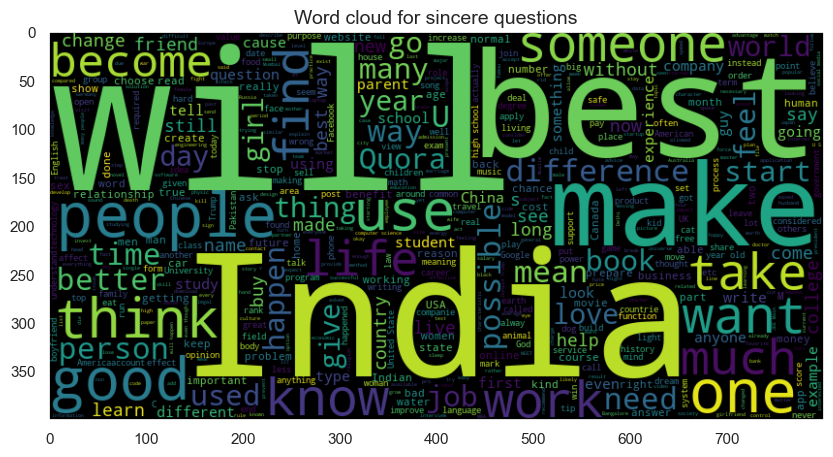

In [6]:
# Look at WordCloud for sincere questions
df_sincere = questions[questions.target == 0]

plt.figure(figsize=(10,10))

wc_sincere = WordCloud(
    max_words = 500,
    width = 800,
    height = 400).generate(" ".join(df_sincere.question_text))

plt.imshow(wc_sincere, interpolation='bilinear')
plt.grid(False)
plt.title("Word cloud for sincere questions",fontsize=14)

plt.show()

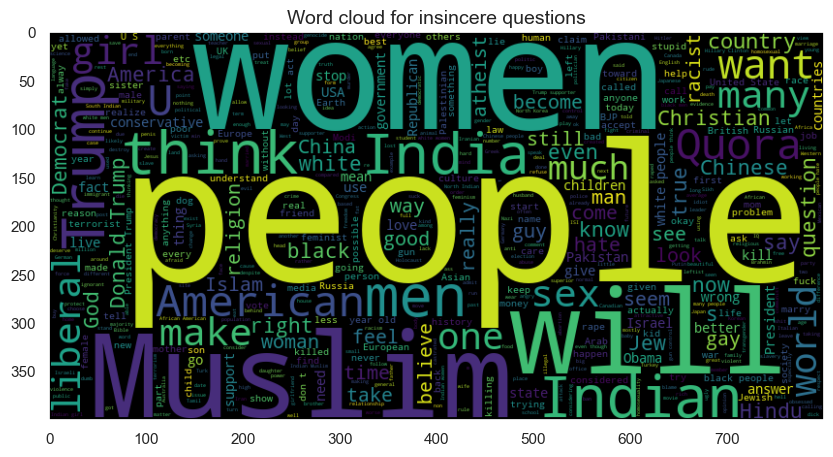

In [7]:
# Look at WordCloud for insincere questions
df_insincere = questions[questions.target == 1]

plt.figure(figsize=(10,10))

wc_insincere = WordCloud(
    max_words = 500,
    width = 800,
    height = 400).generate(" ".join(df_insincere.question_text))

plt.imshow(wc_insincere, interpolation='bilinear')
plt.grid(False)
plt.title("Word cloud for insincere questions",fontsize=14)

plt.show()

In [6]:
# Apply preprocessor to questions dataset
questions['question_text'] = questions['question_text'].apply(preprocessor)

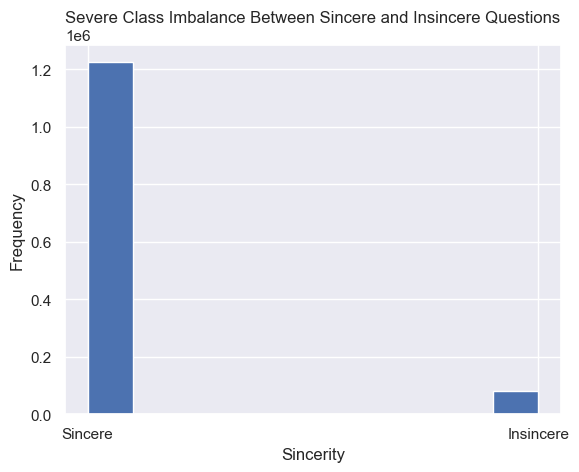

In [7]:
# Look at distribution of sincere and insincere questions
plt.hist(questions.target)

# Add labels and ticks
plt.title('Severe Class Imbalance Between Sincere and Insincere Questions')
plt.ylabel('Frequency')
plt.xlabel('Sincerity')
plt.xticks([0, 1], ['Sincere', 'Insincere']) 
plt.show()

In [8]:
# Compare number of sincere and insincere questions
print("Number of sincere questions:", questions[questions.target == 0].shape[0])
print("Number of insincere questions:", questions[questions.target == 1].shape[0])

Number of sincere questions: 1225312
Number of insincere questions: 80810


In [9]:
# Undersample sincere questions
df_insincere = questions[questions.target == 1]
df_sincere = questions[questions.target == 0].sample(n=len(df_insincere)*3, random_state=2, replace = False)

# Combine sincere and insincere datasets into a new balanced dataset
df_balanced = pd.concat([df_sincere, df_insincere], axis = 0)

# Shuffle df_balanced_train
df_balanced = df_balanced.sample(frac=1)
df_balanced.reset_index(drop=True,inplace=True) # reset index

print(f"After preprocessing, our data contains {df_balanced.shape[0]} questions.")
# Look at at df_balanced_train
df_balanced.head()

After preprocessing, our data contains 323240 questions.


,qid,question_text,target
0,80cb4db41d12f0e524a9,has theresa may used the royal wedding to smok...,1
1,308d71b24e30e42ebbfe,what most dirtiest kinkiest incestious encount...,1
2,bfa726e1da9c520e4e6f,will canada retaliate to us on timber,0
3,c960c08be9e7d6ba03d5,which has more atom if 100g of na 23u and 100g...,0
4,91a93c60b2a6f604fb24,what s the initial capital required to start a...,0


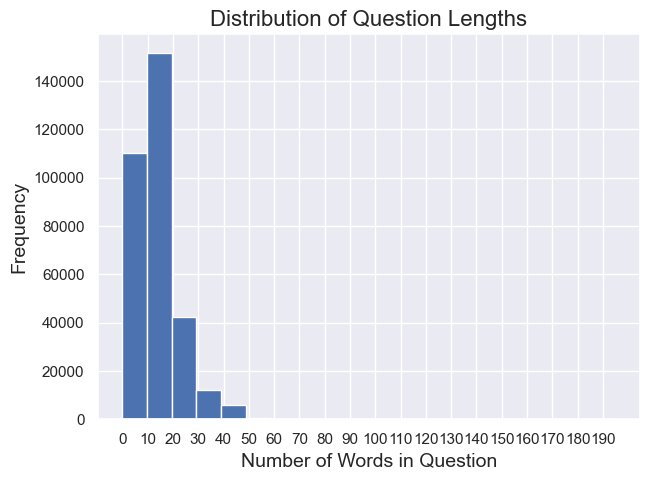

In [10]:
# Compute the length of each question (in words)
df_balanced['question_length'] = df_balanced['question_text'].apply(lambda x: len(x.split()))

# Plot the histogram
plt.figure(figsize=(7, 5))
plt.hist(df_balanced['question_length'], bins=20, alpha=1.0)
plt.title('Distribution of Question Lengths', fontsize=16)
plt.xlabel('Number of Words in Question', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(np.arange(0,200,10))
plt.show()

### Create TensorFlow dataset

In [11]:
# Truncate questions to first 20 words; based on distribution of question lengths, we should be able to capture the gist of most questions with 20 words
# We also truncate to lower dimensionality, which may help our models be less prone to overfittting

def truncate_questions(question):
    return " ".join(question.split(" ")[:20])

df_balanced['question_text'] = df_balanced['question_text'].apply(truncate_questions)

In [12]:
# Double check max question length
max_question_length = max([len(q.split(" ")) for q in df_balanced.question_text])
max_question_length

20

In [13]:
# Popping off target (sincerity) column
target = df_balanced.pop('target')

# Putting together TensorFlow dataset
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_balanced[['question_text']].values, target.values)
)

In [14]:
# Inspection of the first 5 examples
for example in data_tf.take(5):
    # Print question (first 40 characters) and target
    tf.print(example[0].numpy()[0][:40], example[1])

b'has theresa may used the royal wedding t' 1
b'what most dirtiest kinkiest incestious e' 1
b'will canada retaliate to us on timber ' 0
b'which has more atom if 100g of na 23u an' 0
b'what s the initial capital required to s' 0


2024-12-08 16:49:07.176412: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Split data into training, validation, and test sets

In [15]:
# Set random seed for reproducibility
tf.random.set_seed(2)

# Shuffle dataset 
data_tf = data_tf.shuffle(df_balanced.shape[0], reshuffle_each_iteration=False)

# Define splits for training and validation sets
splits = (0.6, 0.2, 0.2)  # 80% for training, 20% for validation, 20% for test

train_split, val_split, test_split = splits

train_split_index = int(train_split * df_balanced.shape[0])
val_split_index = int((train_split + val_split) * df_balanced.shape[0])

# Define the training and validation datasets
data_tf_train = data_tf.take(train_split_index)  # Take the first 60% for training
data_tf_val = data_tf.skip(train_split_index).take(val_split_index - train_split_index)    # Skip the first 60% and use the next 20% for validation
data_tf_test = data_tf.skip(val_split_index) # Skip the first 80%, use the last 20% for testing

### Identify and count unique tokens in the training dataset

In [16]:
# Try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# Create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 69019


2024-12-08 16:49:27.157756: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Sort dictionary by values in descending order and view the top 20 items
dict(sorted(token_counts.items(), key=lambda item: item[1], reverse=True)[:20])

{'the': 93660,
 'is': 61636,
 'what': 58212,
 'to': 57471,
 'a': 56524,
 'in': 50429,
 'of': 46206,
 'i': 41438,
 'do': 39358,
 'are': 37992,
 'how': 37773,
 'and': 37524,
 'why': 35798,
 'for': 26709,
 'you': 26469,
 'can': 24372,
 'it': 20648,
 'that': 17683,
 'if': 14669,
 'my': 14444}

### Encoding sequences of words into sequences of integers

In [18]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

In [19]:
# Try an example to see the encoder in action
example_str = 'why are planets and stars spherical in nature?'
encoder.encode(example_str) # The encode method transforms the text into integers

[14, 30, 12988, 16, 896, 27693, 6, 5676]

In [20]:
# Encode the training, validation, and test sets with the encoder
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_val = data_tf_val.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

In [21]:
# Print first three examples in training data
for example in data_tf_train.take(3):
    print ('----------------------------')
    print('Sequence length:', example[0].shape)
    print('Integer sequence:\n', example[0].numpy())

----------------------------
Sequence length: (14,)
Integer sequence:
 [ 1  2  3  4  5  6  3  7  8  9 10 11 12 13]
----------------------------
Sequence length: (20,)
Integer sequence:
 [14  2 15 16 17 18 19 20 21 19 22 23  2 24 25  1 23 26 27 28]
----------------------------
Sequence length: (13,)
Integer sequence:
 [29 30  3 31 32  6 33 34 35 36 37  6 38]


### Divide datasets into mini-batches

In [22]:
# Define batch size
batch_size = 32

# Batching of training, validation, and test sets
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([max_question_length],[])
)

val_data = data_tf_val.padded_batch(
    batch_size,
    padded_shapes=([max_question_length],[])
)

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([max_question_length],[])
)

In [23]:
# Print first three examples in training data
for example in train_data.take(3):
    print ('----------------------------')
    print('Sequence length:', example[0].shape)
    # print('Integer sequence:\n', example[0].numpy())

----------------------------
Sequence length: (32, 20)
----------------------------
Sequence length: (32, 20)
----------------------------
Sequence length: (32, 20)


2024-12-08 16:49:41.206992: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average sequence length in training mini-batches: 20


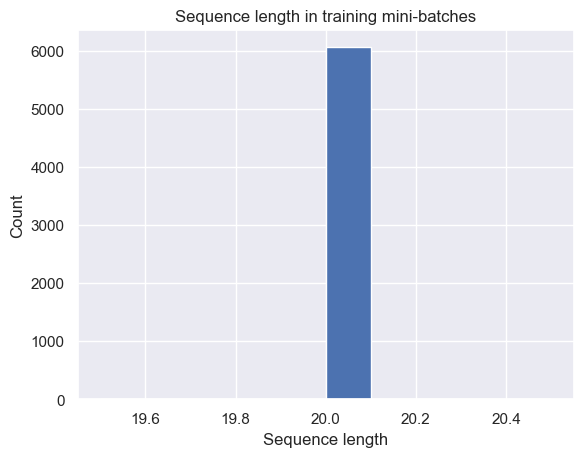

In [24]:
# Plot histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])
    
print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length');

## Section 2: Baseline Model (FFNN with one-hot encoding)

In [25]:
# Convert training data back to NumPy
X_train_np = np.concatenate([batch for batch, label in train_data.as_numpy_iterator()])
Y_train_labels_np = np.concatenate([label for batch, label in train_data.as_numpy_iterator()])

# Convert validation data back to NumPy
X_val_np = np.concatenate([batch for batch, label in val_data.as_numpy_iterator()])
Y_val_labels_np = np.concatenate([label for batch, label in val_data.as_numpy_iterator()])

# Convert test data back to NumPy
X_test_np = np.concatenate([batch for batch, label in test_data.as_numpy_iterator()])
Y_test_labels_np = np.concatenate([label for batch, label in test_data.as_numpy_iterator()])


2024-12-08 16:50:26.010259: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# Define function to limit vocabulary, and assign OOV id
def limit_vocab(sequences, max_token_id, oov_id=1001):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  sequences = sequences.copy()
  reduced_sequences = np.array( [np.where(sequence < max_token_id,sequence,oov_id) for sequence in sequences ] )
  return reduced_sequences

# Reduce vocabulary to 1000 tokens
X_train_reduced = limit_vocab(X_train_np, max_token_id=1001)
X_val_reduced = limit_vocab(X_val_np, max_token_id=1001)
print(X_train_reduced.shape)

(193944, 20)


In [27]:
# Apply one-hot encoding
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
X_val_one_hot = tf.keras.utils.to_categorical(X_val_reduced)

# Limit to 25000 examples, to reduce computational overhead when calculating baseline
X_train_one_hot = X_train_one_hot[:25000]
Y_train_labels_np = Y_train_labels_np[:25000]

X_val_one_hot = X_val_one_hot[:25000]
Y_val_labels_np = Y_val_labels_np[:25000]

print("One hot shape",X_train_one_hot.shape)
print("One hot shape",Y_train_labels_np.shape)
print("One hot shape",X_val_one_hot.shape)
print("One hot shape",Y_val_labels_np.shape)

One hot shape (25000, 20, 1002)
One hot shape (25000,)
One hot shape (25000, 20, 1002)
One hot shape (25000,)


In [28]:
# Parameters
input_length = 20  
def build_baseline_model():
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness
    tf.keras.backend.clear_session()
    tf.random.set_seed(2)

    # Input layer
    inputs = Input(shape=(input_length,1002), name="input_layer")
    
    # Global average pooling
    x = GlobalAveragePooling1D()(inputs)
      
    # Output layer
    outputs = Dense(1, activation='sigmoid', name="output_layer")(x)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="quora_insincere_model")

    # Print model summary
    model.summary()
    
    return model

In [29]:
# Build the model
baseline_model = build_baseline_model()

Model: "quora_insincere_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1002)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1002)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003 (3.92 KB)

 Trainable params: 1,003 (3.92 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Compile model
baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# Train model
tf.random.set_seed(2)
np.random.seed(2)
history_baseline_model = baseline_model.fit(
    x=X_train_one_hot,
    y=Y_train_labels_np,
    validation_data=(X_val_one_hot,Y_val_labels_np), 
    epochs=5)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7340 - loss: 0.6341 - val_accuracy: 0.7538 - val_loss: 0.5463
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7572 - loss: 0.5356 - val_accuracy: 0.7538 - val_loss: 0.5228
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7572 - loss: 0.5153 - val_accuracy: 0.7538 - val_loss: 0.5082
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.7572 - loss: 0.5013 - val_accuracy: 0.7545 - val_loss: 0.4961
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7589 - loss: 0.4896 - val_accuracy: 0.7600 - val_loss: 0.4860


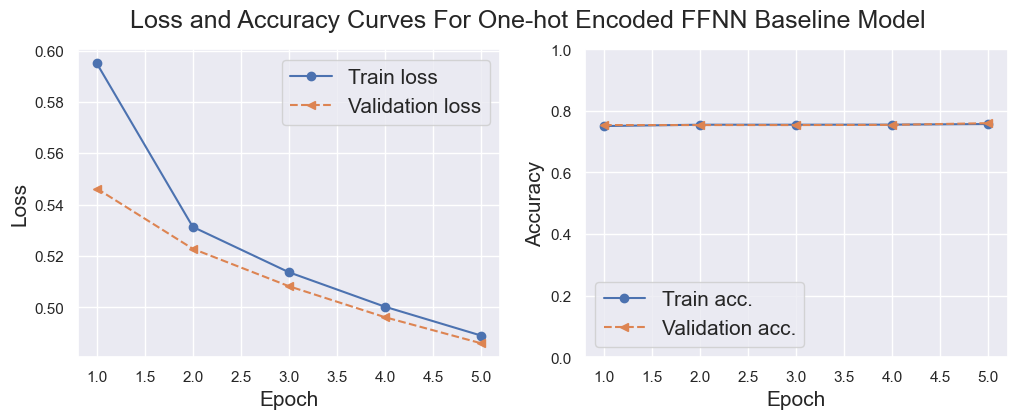

In [32]:
# Look at Loss and Accuracy curves
hist = history_baseline_model.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
fig.suptitle('Loss and Accuracy Curves For One-hot Encoded FFNN Baseline Model', fontsize=18)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)


plt.show()

In [33]:
print("Baseline Model")
# Evaluate on training data
train_loss_baseline, train_accuracy_baseline = baseline_model.evaluate(X_train_one_hot,Y_train_labels_np, verbose=0)
print(f"Training Loss: {train_loss_baseline:.4f}, Training Accuracy: {train_accuracy_baseline:.4f}")

# Evaluate on validation data
val_loss_baseline, val_accuracy_baseline = baseline_model.evaluate(X_val_one_hot,Y_val_labels_np, verbose=0)
print(f"Validation Loss: {val_loss_baseline:.4f}, Validation Accuracy: {val_accuracy_baseline:.4f}")

Baseline Model
Training Loss: 0.4838, Training Accuracy: 0.7606
Validation Loss: 0.4860, Validation Accuracy: 0.7600


This baseline model achieve 76.06% training accuracy and 76.00% validation accuracy. Interestingly, this is extremely close to if we just predicted the majority class (sincere) every time, which would yield 75.0%

## Section 3: Improving over baseline

We iterate through different models, aiming to improve our model over the baseline. We try the following models:
- Model 1: 1 Convolutional Layer with GloVe embeddings, with no finetuning
- Model 2: 1 Convolutional Layer with Paragram embeddings, with no finetuning
- Model 3: 1 Recurrent Layer and multiple Convolutional layers with GloVe embeddings, with Hyperband finetuning
- Model 4: 1 Convolutional Layer with GloVe embeddings, with RandomSearch finetuning

### Importing GloVe embeddings

In [34]:
# Path to the GloVe embeddings file
glove_file_path = './data/embeddings/glove.840B.300d/glove.840B.300d.txt'

# Initialize an empty dictionary to store the embeddings
glove_embeddings = {}

# Define values to skip entirely
values_to_skip = {"Amazon.com", "name@domain.com","Killerseats.com","mylot.com"}

# Load the embeddings from the GloVe file
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            # Convert each vector element with conditions
            vector = np.array([0.0 if x == '.' else float(x) for x in values[1:] if x not in values_to_skip], dtype='float32')
                
        except ValueError as e:
            # Print the word and the error message for further debugging
            print(f"Error processing word '{word}': {e}")
        glove_embeddings[word] = vector

In [35]:
# Preparing embedding layer with GloVe embeddings

# Create a dictionary to see the mapping of token to its index in the encoder
token_to_index = {token: encoder.encode(token)[0] for token in encoder.tokens}

# Parameters
vocab_size_train = len(token_counts) + 2 # Add one for padding token, and one for out of vocab (OOV)
embedding_dim = 300
input_length = 200  # limits length of sentence to 200 tokens

# Initialize the embedding matrix with random values
embedding_matrix_glove = np.random.normal(size=(vocab_size_train, embedding_dim))

# Populate an embedding matrix with GloVe embeddings
for token, index in token_to_index.items():
    embedding_vector = glove_embeddings.get(token)
    if embedding_vector is not None: 
        embedding_matrix_glove[index] = embedding_vector # Update embedding matrix with glove_embedding vector if token is in glove_embeddings
    else:
        embedding_matrix_glove[index] = np.zeros(embedding_dim) # If token is not in glove_embedding, initialize unknown tokens with zeros

In [36]:
embedding_matrix_glove.shape

(69021, 300)

### Importing Paragram embeddings

In [37]:
# Path to the Paragram embeddings file
paragram_file_path = './data/embeddings/paragram_300_sl999/paragram_300_sl999.txt'

# Initialize an empty dictionary to store the embeddings
paragram_embeddings = {}

# Define values to skip entirely
values_to_skip = {"amazon.com","killerseats.com",'name@domain.com','mylot.com'}

# Load the embeddings from the Paragram file
with open(paragram_file_path, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            # Convert each vector element
            vector = np.array([0.0 if x == '.' else float(x) for x in values[1:] if x not in values_to_skip], dtype='float32')
        except ValueError as e:
            print(f"Error processing word '{word}': {e}")
        paragram_embeddings[word] = vector

In [38]:
# Preparing embedding layer with Paragram embeddings
# Parameters
vocab_size_train = len(token_counts) + 2 # Add one for padding token, and one for out of vocab (OOV)
embedding_dim = 300
input_length = 20  # limits length of sentence to 200 tokens

# Initialize the embedding matrix with random values
embedding_matrix_paragram = np.random.normal(size=(vocab_size_train, embedding_dim))

# Populate the embedding matrix with Paragram embeddings
for token, index in token_to_index.items():
    embedding_vector = paragram_embeddings.get(token)
    if embedding_vector is not None: 
        embedding_matrix_paragram[index] = embedding_vector # Update embedding matrix with paragram_embedding vector if token is in paragram_embeddings
    else:
        embedding_matrix_paragram[index] = np.zeros(embedding_dim) # If token is not in paragram_embedding, initialize unknown tokens with zeros

In [39]:
embedding_matrix_paragram.shape

(69021, 300)

### Model 1: 1 Convolutional Layer with GloVe embeddings, with no finetuning

In [40]:
# Build 1 layer convolutional model with pre-trained embeddings

def build_cnn_model_with_embeddings(vocab_size_train, embedding_dim, embedding_matrix):
    # Clear session and set a random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(2)
    
    # Input layer
    inputs = Input(shape=(input_length,), name="input_layer")  # Input length should match input_length in Embedding
    x = Embedding(
        input_dim=vocab_size_train,
        output_dim=embedding_dim,
        weights=[embedding_matrix], # Use embedding matrix
        trainable=False  # Set to True if we want to fine-tune the embeddings
        )(inputs)

    # Add 1 convolutional, dropout, and pooling layer 
    x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = GlobalAveragePooling1D()(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid', name="output_layer")(x)

    # Define and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="quora_insincere_model")
    model.summary()
    
    return model


In [41]:
# Define class weights
class_weights = {0: 1, 1: 3}  # Weights: sincere class is 1, insincere class is 3

In [42]:
# Implementing 1 convolutional layer model with GloVe embeddings
cnn_model_glove = build_cnn_model_with_embeddings(vocab_size_train, embedding_dim, embedding_matrix_glove)

# Compile the model
cnn_model_glove.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model with class weights
history_cnn_model_glove = cnn_model_glove.fit(
    train_data,            # training data
    validation_data=val_data,  # validation data
    epochs=10,             # number of epochs
    class_weight=class_weights # apply class weights
)

Model: "quora_insincere_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 300)        │    20,706,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 128)        │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,860,157 (79.58 MB)

 Trainable params: 153,857 (601.00 KB)

 Non-trainable params: 20,706,300 (78.99 MB)

Epoch 1/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.8622 - loss: 0.5255 - val_accuracy: 0.8824 - val_loss: 0.3133
Epoch 2/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8861 - loss: 0.4454 - val_accuracy: 0.8836 - val_loss: 0.3116
Epoch 3/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.8924 - loss: 0.4239 - val_accuracy: 0.8912 - val_loss: 0.2925
Epoch 4/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8954 - loss: 0.4090 - val_accuracy: 0.8892 - val_loss: 0.2915
Epoch 5/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8986 - loss: 0.3959 - val_accuracy: 0.8913 - val_loss: 0.2916
Epoch 6/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9025 - loss: 0.3837 - val_accuracy: 0.8854 - val_loss: 0.3079
Epoch 7/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.9060 - loss: 0.3722 - val_accuracy: 0.8886 - val_loss: 0.2978
Epoch 8/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9074 - loss: 0

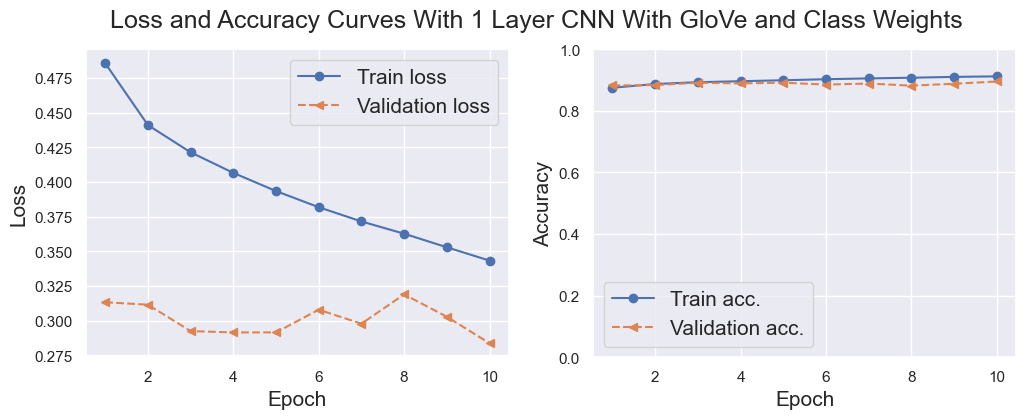

In [43]:
# Look at Loss and Accuracy curves
hist = history_cnn_model_glove.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
fig.suptitle('Loss and Accuracy Curves With 1 Layer CNN With GloVe and Class Weights', fontsize=18)

ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

### Model 2: 1 Convolutional Layer with Paragram embeddings, with no finetuning

In [45]:
# Implementing CNN model with Paragram embeddings and class weights
cnn_model_paragram = build_cnn_model_with_embeddings(vocab_size_train, embedding_dim, embedding_matrix_paragram)

# Compile the model
cnn_model_paragram.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Model: "quora_insincere_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 300)        │    20,560,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 128)        │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,714,057 (79.02 MB)

 Trainable params: 153,857 (601.00 KB)

 Non-trainable params: 20,560,200 (78.43 MB)

In [47]:
# Train the paragram model with class weights
history_cnn_model_paragram = cnn_model_paragram.fit(
    train_data,            # training data
    validation_data=val_data,  # validation data
    epochs=10,             # number of epochs
    class_weight=class_weights # apply class weights
)

Epoch 1/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8520 - loss: 0.5513 - val_accuracy: 0.8794 - val_loss: 0.3145
Epoch 2/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8794 - loss: 0.4649 - val_accuracy: 0.8814 - val_loss: 0.3110
Epoch 3/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8868 - loss: 0.4394 - val_accuracy: 0.8737 - val_loss: 0.3319
Epoch 4/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8905 - loss: 0.4202 - val_accuracy: 0.8787 - val_loss: 0.3181
Epoch 5/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8957 - loss: 0.4042 - val_accuracy: 0.8788 - val_loss: 0.3214
Epoch 6/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8993 - loss: 0.3907 - val_accuracy: 0.8789 - val_loss: 0.3187
Epoch 7/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9032 - loss: 0.3778 - val_accuracy: 0.8785 - val_loss: 0.3222
Epoch 8/10
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9057 - loss: 0

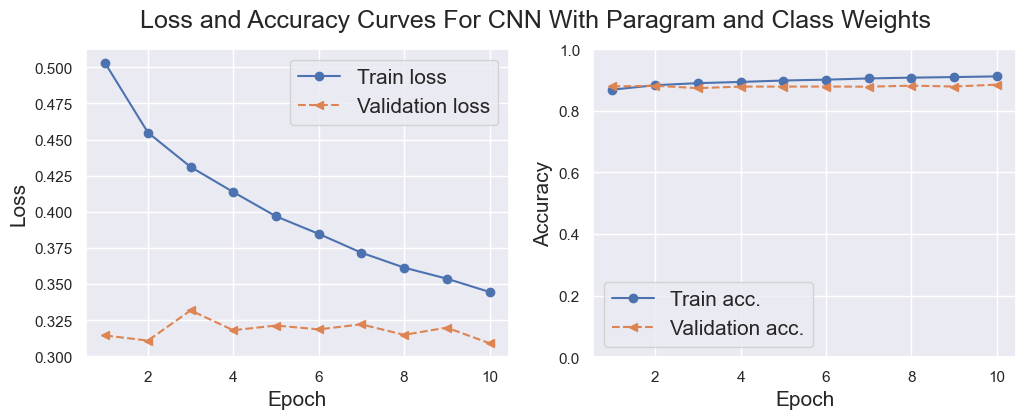

In [48]:
# Look at Loss and Accuracy curves
hist = history_cnn_model_paragram.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
fig.suptitle('Loss and Accuracy Curves For CNN With Paragram and Class Weights', fontsize=18)

ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [44]:
print("1 Convolutional layer with GloVe embeddings")
# Evaluate CNN model with GloVe on training data
train_loss_cnn_glove, train_accuracy_cnn_glove = cnn_model_glove.evaluate(train_data, verbose=0)
print(f"Training Loss: {train_loss_cnn_glove:.4f}, Training Accuracy: {train_accuracy_cnn_glove:.4f}")

# Evaluate CNN model with GloVe on validation data
val_loss_cnn_glove, val_accuracy_cnn_glove = cnn_model_glove.evaluate(val_data, verbose=0)
print(f"Validation Loss: {val_loss_cnn_glove:.4f}, Validation Accuracy: {val_accuracy_cnn_glove:.4f}")

1 Convolutional layer with GloVe embeddings
Training Loss: 0.2038, Training Accuracy: 0.9280
Validation Loss: 0.2837, Validation Accuracy: 0.8953


In [49]:
print("1 Convolutional layer with Paragram embeddings")
# Evaluate CNN model with Paragram on training data
train_loss_cnn_paragram, train_accuracy_cnn_paragram = cnn_model_paragram.evaluate(train_data, verbose=0)
print(f"Training Loss: {train_loss_cnn_paragram:.4f}, Training Accuracy: {train_accuracy_cnn_paragram:.4f}")

# Evaluate CNN model with Paragram on validation data
val_loss_cnn_paragram, val_accuracy_cnn_paragram = cnn_model_paragram.evaluate(val_data, verbose=0)
print(f"Validation Loss: {val_loss_cnn_paragram:.4f}, Validation Accuracy: {val_accuracy_cnn_paragram:.4f}")

1 Convolutional layer with Paragram embeddings
Training Loss: 0.1927, Training Accuracy: 0.9326
Validation Loss: 0.3091, Validation Accuracy: 0.8852


Given that the validation loss for the CNN model with GloVe embeddings is slightly lower and the validation accuracy slightly higher than the same CNN model with Paragram embeddings, we pick GloVe embeddings to implement going forward.

### Model 3: 1 Recurrent Layer and multiple Convolutional layers with GloVe embeddings, with Hyperband finetuning
Below is the code we used a tuner to add a Recurrent layer, and give the tuner options to add multiple convolutional layers, along with hyperparameter tuning. 

In [47]:
# Define an instance of the EarlyStopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [ ]:
# # Define hyperparameter tuning model builder
def model_builder(hp):
    # Clear session and set a random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(2)
    
    # Input layer
    inputs = Input(shape=(input_length,), name="input_layer")
    
    # Embedding layer
    x = Embedding(
        input_dim=vocab_size_train,
        output_dim=embedding_dim,
        input_length=input_length,
        weights=[embedding_matrix_glove],
        trainable=False,
        name="embedding"
    )(inputs)

    x = tf.keras.layers.SimpleRNN(
        units=hp.Int('rnn_units', min_value=32, max_value=128, step=32),
        return_sequences=True,  # True to connect with Conv1D
        dropout=hp.Choice('rnn_dropout', [0.2, 0.3, 0.4]),
    name="simple_rnn_layer")(x)
    
    # Add convolutional blocks
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        # Convolution layer
        x = Conv1D(
            filters=hp.Int(f'filters_{i+1}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Int(f'kernel_size_{i+1}', min_value=1, max_value=5, step=1),
            padding='same',
            activation=hp.Choice(f'activation_{i+1}', ['relu', 'tanh']),
            name=f'conv_{i+1}'
        )(x)
        
        # Dropout
        x = Dropout(rate=hp.Choice(f'dropout_{i+1}', [0.2, 0.3, 0.4]))(x)
        
        # Max pooling
        x = MaxPooling1D(pool_size=hp.Int(f'pool_size_{i+1}', min_value=1, max_value=5, step=1))(x)
    
    # Global average pooling (outside the loop)
    x = GlobalAveragePooling1D()(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid', name="output_layer")(x)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="quora_insincere_model")

    # Define optimizer with a tunable learning rate
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
    optimizer_choice = hp.Choice('optimizer', ['sgd', 'adam'])
    
    if optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Keras Tuner Hyperband
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=20,
    directory='hyperband_models',
    project_name='keras_tuning'
)

# Perform hyperparameter search
tuner.search(
    train_data,  # Ensure this is (X_train, y_train)
    epochs=20,
    validation_data=val_data,  # Ensure this is (X_val, y_val)
    callbacks=[early_stopping],
    class_weight=class_weights
)


Reloading Tuner from hyperband_models/keras_tuning/tuner0.json


In [39]:
model_rnn_cnn_specs = {'activation_1': 'relu',
 'activation_2': 'relu',
 'activation_3': 'relu',
 'dropout_1': 0.4,
 'dropout_2': 0.2,
 'dropout_3': 0.4,
 'filters_1': 128,
 'filters_2': 96,
 'filters_3': 128,
 'kernel_size_1': 5,
 'kernel_size_2': 1,
 'kernel_size_3': 3,
 'learning_rate': 0.1,
 'num_layers': 2,
 'optimizer': 'sgd',
 'pool_size_1': 3,
 'pool_size_2': 2,
 'pool_size_3': 3,
 'rnn_dropout': 0.4,
 'rnn_units': 128,
 'tuner/bracket': 0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}
model_rnn_cnn_specs

{'activation_1': 'relu',
 'activation_2': 'relu',
 'activation_3': 'relu',
 'dropout_1': 0.4,
 'dropout_2': 0.2,
 'dropout_3': 0.4,
 'filters_1': 128,
 'filters_2': 96,
 'filters_3': 128,
 'kernel_size_1': 5,
 'kernel_size_2': 1,
 'kernel_size_3': 3,
 'learning_rate': 0.1,
 'num_layers': 2,
 'optimizer': 'sgd',
 'pool_size_1': 3,
 'pool_size_2': 2,
 'pool_size_3': 3,
 'rnn_dropout': 0.4,
 'rnn_units': 128,
 'tuner/bracket': 0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

The specifications from the model with a RNN is given in the dictionary above, with 1 RNN layer and 3 CNN layers. However, this did not outperform Model 1, which simply had 1 Convolutional layer and GloVe embeddings. We will thus conduct hyperparameter tuning with only 1 Convolutional layer and GloVe embeddings to see if we can outperform Model 1

### Model 4: 1 Convolutional Layer with GloVe embeddings, with RandomSearch finetuning

In [119]:
# Define the hyperparameter tuning model
from tensorflow.keras.optimizers import Adam
def model_builder(hp):
    # Clear session and set a random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(2)
    
    # Input layer
    inputs = Input(shape=(20,), name="input_layer")  # Input length fixed to 20
    x = Embedding(
        input_dim=vocab_size_train,
        output_dim=embedding_dim,
        weights=[embedding_matrix_glove],  # Use embedding matrix
        trainable=False  # Set to True if we want to fine-tune the embeddings
    )(inputs)

    # Convolutional layer with tunable parameters
    x = Conv1D(
        filters=hp.Int('filters', min_value=64, max_value=256, step=32),  # Tune number of filters
        kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),  # Tune kernel size
        padding='same',
        activation='relu'
    )(x)

    # Dropout and pooling layers
    x = Dropout(rate=0.5)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = GlobalAveragePooling1D()(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid', name="output_layer")(x)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="quora_insincere_model")

    # Compile the model with a tunable learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2])  # Tune learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of trials to run
    directory='random_search_tuning',  # Directory to save tuning results
    project_name='conv1d_tuning'  # Project name
)

# Run the search
tuner.search(
    train_data,  # Training data
    validation_data=val_data,  # Validation data
    epochs=5,  # Number of epochs for each trial
    callbacks=[early_stopping],  # Include early stopping
    class_weight=class_weights  # Class weights for imbalance
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best number of filters: {best_hps.get('filters')}")
print(f"Best kernel size: {best_hps.get('kernel_size')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 03m 39s]
val_accuracy: 0.8925721049308777

Best val_accuracy So Far: 0.8970115184783936
Total elapsed time: 00h 28m 32s
Best number of filters: 256
Best kernel size: 2
Best learning rate: 0.0005


The results seems promising, although the best validation accuracy is extremely close to that of Model 1's. We train the hypertuned model and observe the results.

In [ ]:
# Build the hypertuned model
hypertuned_cnn_model = tuner.hypermodel.build(best_hps)

# Compile the hypertuned model
hypertuned_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = hypertuned_cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Increase epochs for final training
    class_weight=class_weights  # Apply class weights
)

Epoch 1/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8558 - loss: 0.5363 - val_accuracy: 0.8854 - val_loss: 0.3210
Epoch 2/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8859 - loss: 0.4505 - val_accuracy: 0.8910 - val_loss: 0.3015
Epoch 3/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8913 - loss: 0.4313 - val_accuracy: 0.8944 - val_loss: 0.2928
Epoch 4/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8946 - loss: 0.4188 - val_accuracy: 0.8958 - val_loss: 0.2911
Epoch 5/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8972 - loss: 0.4077 - val_accuracy: 0.8950 - val_loss: 0.2901
Epoch 6/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8999 - loss: 0.3984 - val_accuracy: 0.8961 - val_loss: 0.2865
Epoch 7/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9014 - loss: 0.3910 - val_accuracy: 0.8925 - val_loss: 0.2934
Epoch 8/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9027 - loss: 0

Unfortunately the model seems to overfit and not outperform the original Model 1 either. We will thus retrain Model 1 with early stopping now to train the model as far as possible without overfitting, and pick the best weights.

## Section 4: Final model and results

### Model 5: Model 1 (1 Convolutional layer with GloVe embeddings), but retrained with early stopping this time to prevent overfitting and restore best weights

In [48]:
# Implementing 1 convolutional layer model with GloVe embeddings
cnn_model_glove_final = build_cnn_model_with_embeddings(vocab_size_train, embedding_dim, embedding_matrix_glove)

# Compile the model
cnn_model_glove_final.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Train the model with class weights
history_cnn_model_glove_final = cnn_model_glove_final.fit(
    train_data,            # training data
    validation_data=val_data,  # validation data
    epochs=20,             # number of epochs
    class_weight=class_weights, # apply class weights
    callbacks=[early_stopping] # add early stopping
)

Model: "quora_insincere_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 300)        │    20,706,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 128)        │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,860,157 (79.58 MB)

 Trainable params: 153,857 (601.00 KB)

 Non-trainable params: 20,706,300 (78.99 MB)

Epoch 1/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8622 - loss: 0.5234 - val_accuracy: 0.8830 - val_loss: 0.3091
Epoch 2/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.8860 - loss: 0.4452 - val_accuracy: 0.8887 - val_loss: 0.2989
Epoch 3/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8915 - loss: 0.4239 - val_accuracy: 0.8891 - val_loss: 0.3003
Epoch 4/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8956 - loss: 0.4081 - val_accuracy: 0.8889 - val_loss: 0.3014
Epoch 5/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8986 - loss: 0.3964 - val_accuracy: 0.8985 - val_loss: 0.2695
Epoch 6/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9022 - loss: 0.3827 - val_accuracy: 0.8949 - val_loss: 0.2839
Epoch 7/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9042 - loss: 0.3728 - val_accuracy: 0.8972 - val_loss: 0.2743
Epoch 8/20
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9072 - loss: 0

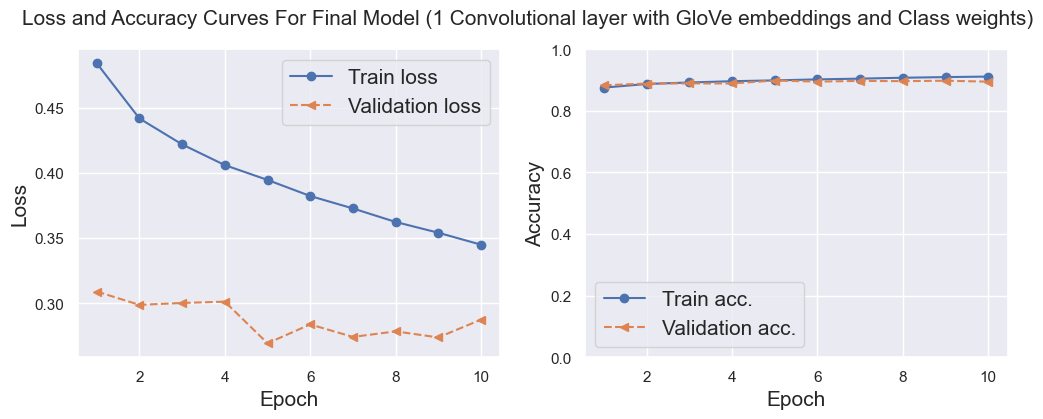

In [52]:
# Look at Loss and Accuracy curves
hist = history_cnn_model_glove_final.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
fig.suptitle('Loss and Accuracy Curves For Final Model (1 Convolutional layer with GloVe embeddings and Class weights)', fontsize=15)

ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [50]:
# Evaluate final model on training data
train_loss_final, train_accuracy_final = cnn_model_glove_final.evaluate(train_data, verbose=0)
print(f"Training Loss: {train_loss_final:.4f}, Training Accuracy: {train_accuracy_final:.4f}")

# Evaluate final model on validation data
val_loss_final, val_accuracy_final = cnn_model_glove_final.evaluate(val_data, verbose=0)
print(f"Validation Loss: {val_loss_final:.4f}, Validation Accuracy: {val_accuracy_final:.4f}")

Training Loss: 0.2330, Training Accuracy: 0.9151
Validation Loss: 0.2695, Validation Accuracy: 0.8985


In [51]:
print('Test accuracy:',cnn_model_glove_final.evaluate(test_data)[1])

2021/2021 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9000 - loss: 0.2666
Test accuracy: 0.900894045829773


Our model generalizes well as....

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions for the test data
y_true = np.concatenate([label for _, label in test_data])  # Extract true labels from test data
y_pred_prob = cnn_model_glove_final.predict(test_data)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions (threshold=0.5)


2024-12-08 17:11:52.673848: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2021/2021 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


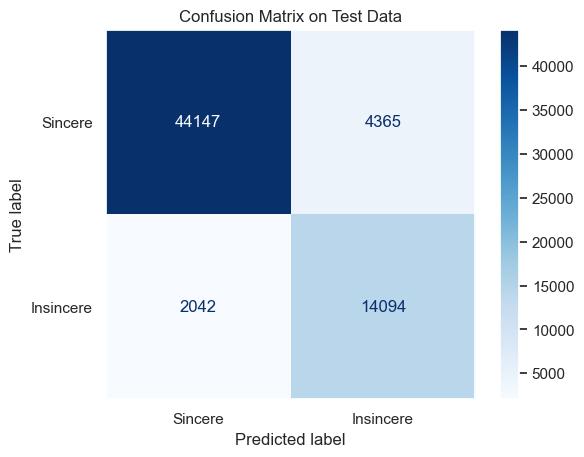

In [62]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sincere', 'Insincere'])
disp.plot(cmap='Blues')
plt.grid(0)
plt.title("Confusion Matrix on Test Data")
plt.show()

The confusion matrix for the test data shows 90.09% accuracy indicating that our model generalizes well.

Our model also has a precision of 76.4% and recall of 87.3%.

## Section 5: Conclusion and Implications

**Ethical Considerations**

- Whenever there is online content moderation there will be discussion of censorship and free speech. Ensuring a safe platform also means that the censorship of insincere questions must be carefully considered.
- If our model were taken out of Quora’s context, there could be a negative social impact. For example, if a news or political organization were to use it to suppress genuine and potentially critical comments on their material.
- What constitutes a “sincere” question can be somewhat subjective and context-dependent. For example, Quora defines insincere questions as those that are not “grounded in reality” which may differ greatly based on different contexts. Quora also considers insincere questions those that “use sexual content for shock value, and not to seek genuine answer”, which may be difficult to determine.

**Limitations and Further Research**

- It is possible that there are biases present in the training data, leading to a misrepresentation of Quora questions which could limit the efficacy of this model applied in Quora’s context. It is also possible that there is bias in the labeling, given the subjective nature of what is sincere.
- Understanding how the data was collected and testing our model on additional sets of Quora questions could help us understand and mitigate the presence of biases. 
Model use must also stay within online forum question domain. Different models must be trained for different moderation such as YouTube comments or live streaming chats
- Language and context can be complex, and can vary across countries and cultures; what is sincere in a culture may sound insincere in another.
- Understanding how Quora’s questions vary across various subsets such as geographic location may be an important next step for further research, which could also alleviate some ethical considerations.

**Conclusion**

- Online content moderation can be achieved with a reasonably high degree of accuracy and is worth investing resources into. Misclassified insincere questions can always be handled with an appeal functionality that pushes the question for human review.
